<a href="https://colab.research.google.com/github/lowbee2019/Algorithm/blob/master/MyModel-demoV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emnist

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import collections
import copy
import random
import emnist

# Server Initialization

In [3]:
class ParamServer(object):
  def __init__(self,init_model_path):
    self.init_model_path = init_model_path
    self.round = 0
    self.optimizer="adam"
    self.loss = "sparse_categorical_crossentropy"
    self.metrics =['accuracy']
    self.loss_acc=[]

  def PreTrain(self,model,data,labels,batch_size=32,epochs=5):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    _metrics = model.fit(data,labels,batch_size,epochs)
    return model
  
  def PreEval(self,model,test_data,test_labels):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    self.loss_acc.append(model.evaluate(test_data,test_labels))


## Mnist数据集的预处理

In [4]:
mnist = tf.keras.datasets.mnist
train,test = mnist.load_data()
x_train,y_train = train
x_test,y_test = test
x_train,x_test = x_train/255.0,x_test/255.0

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
x_train.shape

(60000, 28, 28)

## 模型的定义

In [6]:
class FLModel(tf.keras.Model):
  def __init__(self,row,col,num_classes=62,*args,**kwargs):
    super(FLModel,self).__init__(*args,**kwargs)
    self.row = row
    self.col = col
    self.num_classes = num_classes
    self.flatten = tf.keras.layers.Flatten(input_shape=(row,col))
    self.dense_1 = tf.keras.layers.Dense(500,activation='relu',name="dense_1")
    self.dense_2 = tf.keras.layers.Dense(num_classes,activation='softmax',name="dense_2")
    self.drop = tf.keras.layers.Dropout(0.2)


  def call(self,inputs):
    x = self.flatten(inputs)
    x = self.dense_1(x)
    x = self.drop(x)
    x = self.dense_2(x)
    return x
  
  def copy(self):
    NewModel = FLModel(self.row,self.col,self.num_classes)
    _ = NewModel(np.expand_dims(tf.zeros([self.row,self.col]),0))
    ##Layers
    NewVars = NewModel.trainable_variables #此处为空列表，因为没有训练,这个地方参数传递是不是有问题
    OldVars = self.trainable_variables
    for n,o in zip(NewVars,OldVars):
      n.assign(o.numpy())
    return NewModel

  # def compute_output_shape(self,input_shape):
  #   shape = tf.TensorShape(input_shape).as_list()
  #   shape[-1] = self.num_classes
  #   return tf.TensorShape(shape)

#Client Initialization
模型训练和评估都要重写

In [7]:
class Client(object):
  def __init__(self,id,model=None,Train_dataset=None,Test_dataset=None):
    self.id = id
    self.model = model
    self.Train_dataset = Train_dataset
    self.Test_dataset = Test_dataset
    # from ParamServer
    self.ParamModel = None
    self.num_epochs = 5
    self.batch_size = 32
    self.shuffle_buffer = 100
    self.prefetch_buffer = 10
    ## 


  def ReceiveModel(self,ParamModel,num_epochs=1,batch_size=32,shuffle_buffer=100,prefetch_buffer=10):
    self.ParamModel = ParamModel
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.shuffle_buffer = shuffle_buffer
    self.prefetch_buffer = prefetch_buffer
  

  def preprocess(self,dataset):
    def batch_format_fn(element):
      return collections.OrderedDict(
            
            x = tf.reshape(element['pixels'],[-1,784]),
            y = tf.reshape(element['label'],[-1,1])
          )
    return dataset.repeat(self.num_epochs).shuffle(self.shuffle_buffer).batch(
        self.batch_size).map(batch_format_fn).prefetch(self.prefetch_buffer)

  def NodeTrain(self):
    model = self.ParamModel
    # pre_data = self.preprocess(self.Train_dataset)
    # print(type(pre_data))
    # model.fit(x=pre_data['x'],y=pre_data['y'],batch_size=self.batch_size,epochs=self.num_epochs)
    # x = np.array([i['pixels'].numpy() for i in self.Train_dataset])
    # y = np.array([i['label'].numpy() for i in self.Train_dataset])
    x,y = self.Train_dataset
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    _metrics = model.fit(x,y,batch_size=self.batch_size,epochs=self.num_epochs)
    self.model = model

  def NodeEval(self):
    x,y = self.Test_dataset
    self.model.evaluate(x,y)


# 阶段一：为Client分配数据（预处理工作）

In [ ]:
# emnist_dataset = emnist.extract_training_samples('byclass')

In [24]:
letters_dataset = emnist.extract_training_samples('letters')

In [25]:
letters_dataset = (letters_dataset[0]/255.0,letters_dataset[1]+9)

In [26]:
set(letters_dataset[1])

{10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35}

In [36]:
def create_data_for_clients(LetterSet,Num,DigitSet=train,TargetRate=0.7):
  #Alpha: 需要掺入mnist的占比
  #Beta: Emnist中数字的占比
  # Beta = 34.0/73.0
  Beta = 0
  if TargetRate < Beta:
    Alpha = 0
  else:
    Alpha = (TargetRate-Beta)/(1-Beta)
  DigitNum = int(Alpha*Num)
  LetterNum = Num-DigitNum
  x_sequence = []
  y_sequence = []
  print(DigitNum,LetterNum)
  if DigitNum > 0:
    for i in range(DigitNum):
      index = random.randint(0,len(DigitSet[0])-1)
      x_sequence.append(DigitSet[0][index])
      y_sequence.append(DigitSet[1][index])
  if LetterNum > 0:
    for i in range(LetterNum):
      index = random.randint(0,len(LetterSet[0])-1)
      x_sequence.append(LetterSet[0][index])
      y_sequence.append(LetterSet[1][index])
      #y_sequence.append(random.randint(0,9))
  return (np.array(x_sequence),np.array(y_sequence))

In [35]:
print(letters_dataset[1][2],letters_dataset[1][1])

25 16


In [ ]:
# def create_data_for_clients(BasicSet,Num):
#   x_sequence = []
#   y_sequence = []
#   for i in range(Num):
#     index = random.randint(0,Num-1)
#     x_sequence.append(BasicSet[0][index])
#     y_sequence.append(BasicSet[1][index])
#   return (np.array(x_sequence),np.array(y_sequence))

In [28]:
NUM_CLIENTS = 12
NUM_TRAIN_SAMPLE_CLIENT = 2560
NUM_TEST_SAMPLE_CLIENT = 256

In [37]:
clients=[]
for i in range(NUM_CLIENTS):
  clients.append(Client(i,
                        Train_dataset=create_data_for_clients(letters_dataset,NUM_TRAIN_SAMPLE_CLIENT,TargetRate=random.random()),
                        Test_dataset=create_data_for_clients(letters_dataset,NUM_TEST_SAMPLE_CLIENT))
  )

1236 1324
179 77
2408 152
179 77
1870 690
179 77
111 2449
179 77
884 1676
179 77
131 2429
179 77
1447 1113
179 77
1122 1438
179 77
1290 1270
179 77
363 2197
179 77
729 1831
179 77
719 1841
179 77


Show DataSet

In [14]:
import matplotlib.pyplot as plt

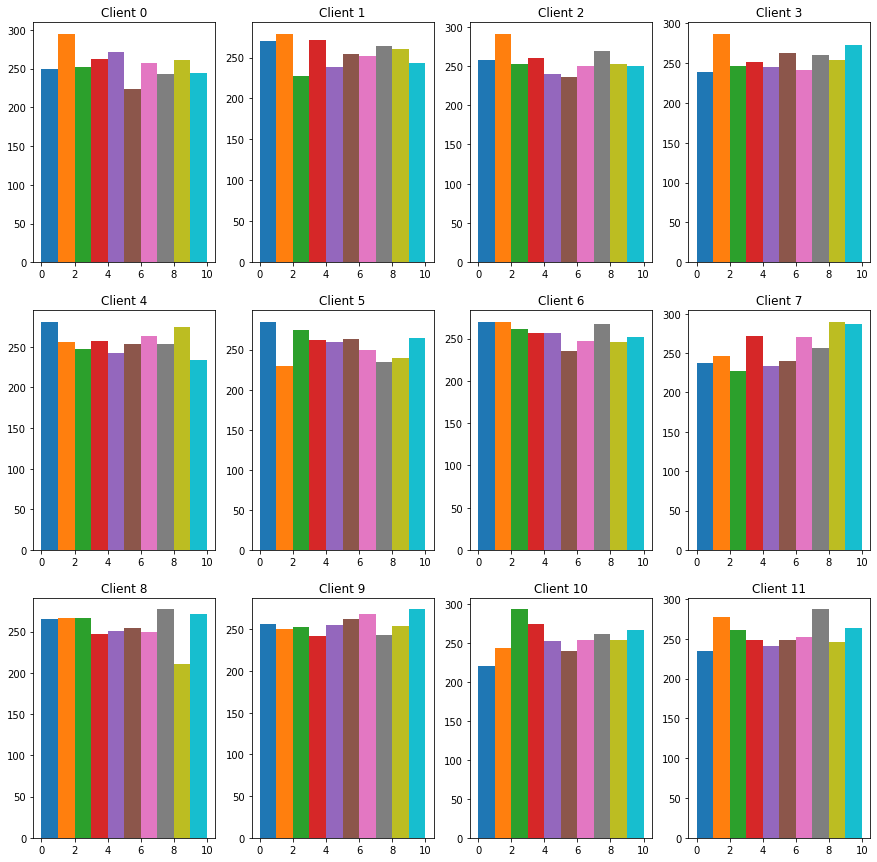

In [38]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = collections.defaultdict(list)
  for label in client_dataset[1]:
    plot_data[label].append(label)
  plt.subplot(3,4,i+1)
  plt.title('Client {}'.format(i))
  for j in range(len(plot_data)):
    plt.hist(
        plot_data[j],
        density = False,
        bins = [x for x in range(len(plot_data)+1)]
    )

显示一下数字与字母的对比


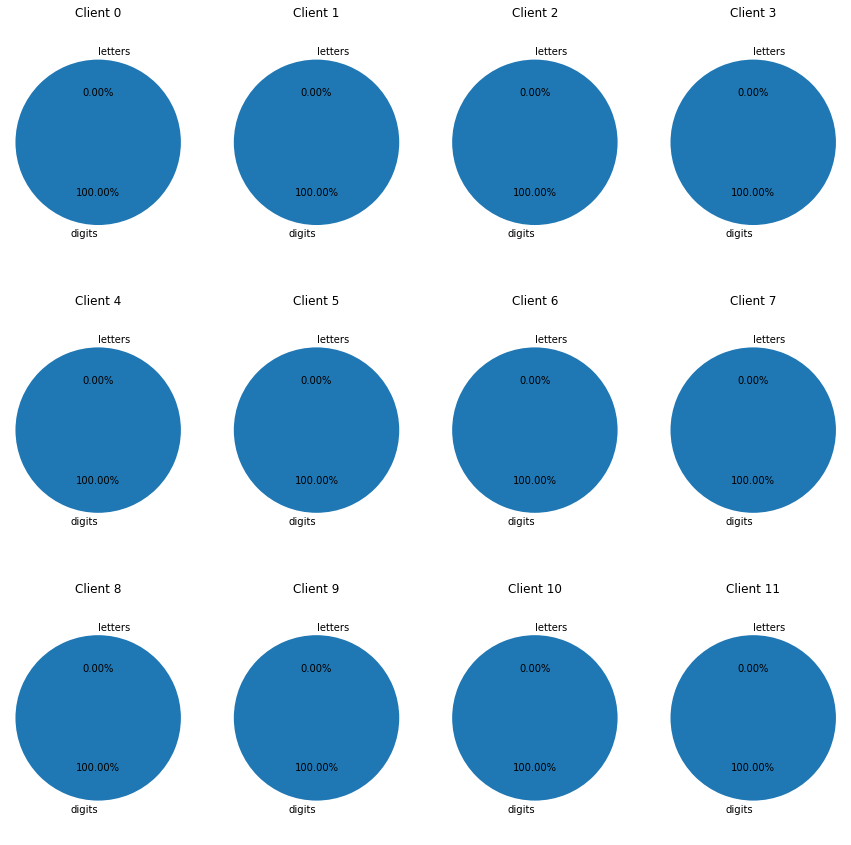

In [39]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = {0:0,1:0}
  plot_labels = ['digits','letters']
  for label in client_dataset[1]:
    label = 0 if label < 10 else 1
    plot_data[label]+=1
  # print(plot_data)
  data_labels = list(sorted(plot_data.keys()))
  # print(data_labels)
  data_nums = [plot_data[i] for i in data_labels]
  colors = ['red','blue']
  plt.subplot(3,4,i+1)
  patches,text1,text2 = plt.pie(data_nums,
                              labels=plot_labels,
                              autopct='%3.2f%%',
                              shadow=False,
                              startangle=90,
                              pctdistance=0.6)
  plt.axis('equal')
  plt.title('Client {}'.format(i))
plt.show()


#阶段二：中央服务器下发模型

Distance Between two models

In [40]:
def Distance(HookModel,TestModel):
  len_it = len(HookModel.trainable_variables)
  Hook_weights=[]
  Test_weights=[]
  for index in range(len_it):
    Hook_weights.append(HookModel.trainable_variables[index].numpy())
    Test_weights.append(TestModel.trainable_variables[index].numpy())
  target = []
  dis_norm2=[]
  for i in range(len_it):
    target.append(Hook_weights[i]-Test_weights[i])
    dis_norm2.append(np.linalg.norm(target[i],2))
  weight_weights = np.ones([len_it,1])
  #调整权重
  # weight_weights[0]=0
  # weight_weights[1]=0
  dis = np.dot(dis_norm2,weight_weights)
  return dis
  # return dis_norm2

In [41]:
def BetterNode(clients,model,Total_NUM,FedAvg_NUM):
  NodeDict=collections.OrderedDict()
  for i in range(Total_NUM):
    NodeDict[i] = Distance(model,clients[i].model)
  Dlst = sorted(NodeDict.items(),key=lambda x:x[1])
  NodeList = []
  for i in range(FedAvg_NUM):
    NodeList.append(Dlst[i][0])
  return NodeList

模型初始化

In [42]:
InitModel = FLModel(row=28,col=28,num_classes=10)
S = ParamServer("")

In [43]:
S.PreEval(InitModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.3641 - accuracy: 0.0612


In [44]:
SendModel = InitModel

In [45]:
SendModel = S.PreTrain(InitModel,x_train[0:200],y_train[0:200],epochs=1)
S.PreEval(SendModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.6845 - accuracy: 0.5640


# 阶段三：Clients 训练节点数据并聚合


In [46]:
def FedAvg(NUM_CLIENTS,model,FedAvg_NUM=7):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  FedNodeList=BetterNode(clients,iterModel,NUM_CLIENTS,FedAvg_NUM)
  print("FedAvg Node is",FedNodeList)
  # Cut=2
  # for c in range(Cut):
  #   # tmp =np.array(iterModel.trainable_variables[c].numpy(),dtype='float64')
  #   all_weights.append(iterModel.trainable_variables[c].numpy())

  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in FedNodeList:
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/FedAvg_NUM)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return (iterModel,FedNodeList)

In [47]:
NUM_EPOCHS = 20

In [48]:
NodeList = []
participator=NUM_CLIENTS
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy(),)
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  if participator < int(0.6*NUM_CLIENTS):
    participator = int(0.6*NUM_CLIENTS) 
  FedModel,li = FedAvg(NUM_CLIENTS,SendModel,FedAvg_NUM=participator)
  participator = participator-1
  NodeList.append(li)
  S.PreEval(FedModel,x_test,y_test)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
80/80 [==============================] - 1s 4ms/step - loss: 16.5832 - accuracy: 0.2542
FedAvg Node is [1, 6, 2, 4, 0, 11, 8, 7, 10, 9, 3, 5]
313/313 [==============================] - 1s 2ms/step - loss: 1.5695 - accuracy: 0.8607
EPOCHS 1 is starting...
80/80 [==============================] - 1s 4ms/step - loss: 5.7031 - accuracy: 0.2877
FedAvg Node is [1, 2, 0, 6, 4, 7, 8, 11, 10, 9, 3]
313/313 [==============================] - 1s 2ms/step - loss: 1.8646 - accuracy: 0.8761
EPOCHS 2 is starting...
80/80 [==============================] - 1s 4ms/step - loss: 3.3337 - accuracy: 0.2943
FedAvg Node is [1, 2, 6, 0, 8, 7, 4, 10, 11, 9]
313/313 [==============================] - 1s 2ms/step - loss: 2.0531 - accuracy: 0.8680
EPOCHS 3 is starting...
80/80 [==============================] - 1s 4ms/step - loss: 2.7605 - accuracy: 0.3079
FedAvg Node is [1, 2, 6, 8, 0, 4, 7, 11, 10]
313/313 [==============================] - 1s 2ms/step - loss: 2.1358 - accuracy: 0.8362
E

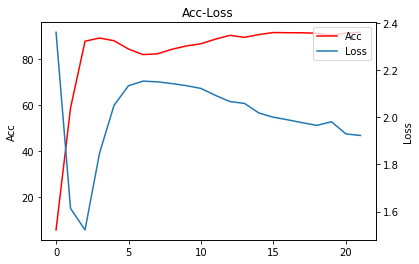

In [49]:
#deal the data
S_acc =[S.loss_acc[i][1]*100 for i in range(len(S.loss_acc))]
S_loss =[S.loss_acc[i][0] for i in range(len(S.loss_acc))]

#prepare show image
x = np.arange(len(S.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_title('Acc-Loss')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss,label='Loss')
ax2.set_ylabel('Loss')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

In [50]:
NodeList

[[1, 6, 2, 4, 0, 11, 8, 7, 10, 9, 3, 5],
 [1, 2, 0, 6, 4, 7, 8, 11, 10, 9, 3],
 [1, 2, 6, 0, 8, 7, 4, 10, 11, 9],
 [1, 2, 6, 8, 0, 4, 7, 11, 10],
 [1, 2, 6, 0, 8, 7, 11, 10],
 [1, 2, 6, 8, 7, 0, 10],
 [1, 6, 2, 8, 0, 4, 11],
 [1, 2, 8, 6, 0, 9, 7],
 [1, 2, 6, 0, 11, 4, 9],
 [1, 2, 0, 6, 11, 4, 8],
 [1, 6, 2, 8, 11, 0, 4],
 [1, 6, 0, 2, 8, 7, 11],
 [1, 2, 6, 8, 4, 0, 11],
 [1, 6, 2, 11, 4, 8, 0],
 [1, 2, 0, 8, 6, 4, 11],
 [1, 2, 6, 8, 11, 0, 4],
 [1, 2, 8, 6, 11, 0, 10],
 [1, 2, 6, 0, 8, 7, 10],
 [1, 0, 8, 2, 11, 6, 7],
 [1, 2, 6, 8, 11, 7, 4]]

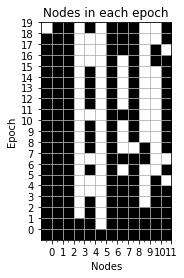

In [51]:
#deal the data
img = np.ones(shape=(NUM_EPOCHS,NUM_CLIENTS),dtype=int)
for i in range(len(NodeList)):
  for j in NodeList[i]:
    img[i][j]=0
#prepare show image
len_n = len(S.loss_acc)
ax = plt.gca()
ax.set_xlim(-0.5,NUM_CLIENTS-0.5)
ax.set_ylim(-0.5,9.5)
miloc = plt.MultipleLocator(1)
ax.xaxis.set_minor_locator(miloc)
plt.grid()
plt.title("Nodes in each epoch")
plt.imshow(img*255,cmap='gray')
plt.axis('on')
plt.xlabel('Nodes')
plt.ylabel('Epoch')
x = np.arange(0.5,NUM_CLIENTS+0.5,1)
y = np.arange(0.5,NUM_EPOCHS+0.5,1)
plt.xticks()
plt.yticks(y,(int(i-0.5) for i in y))
plt.xticks(x,(int(i-0.5) for i in x))
plt.show()

设置对照组，即普通的FedAvg

In [52]:
def FedAvg_Baseline(NUM_CLIENTS,model):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')
    for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/NUM_CLIENTS)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [53]:
InitModel = FLModel(row=28,col=28,num_classes=10)
S2 = ParamServer("")
S2.PreEval(InitModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.3588 - accuracy: 0.0802


In [54]:
SendModel = InitModel

In [55]:
SendModel = S2.PreTrain(InitModel,x_train[0:200],y_train[0:200],epochs=1)
S2.PreEval(SendModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.6726 - accuracy: 0.5806


In [56]:
NUM_EPOCHS = 20

In [57]:
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  FedModel = FedAvg_Baseline(NUM_CLIENTS,SendModel)
  S2.PreEval(FedModel,x_test,y_test)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 1.5485 - accuracy: 0.8712
EPOCHS 1 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 1.8610 - accuracy: 0.8841
EPOCHS 2 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.0497 - accuracy: 0.8762
EPOCHS 3 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.1236 - accuracy: 0.8498
EPOCHS 4 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.1541 - accuracy: 0.8167
EPOCHS 5 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.1764 - accuracy: 0.8043
EPOCHS 6 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.1634 - accuracy: 0.8144
EPOCHS 7 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.1599 - accuracy: 0.8040
EPOCHS 8 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.1575 - 

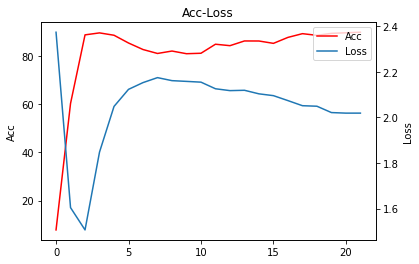

In [58]:
S_acc2 =[S2.loss_acc[i][1]*100 for i in range(len(S2.loss_acc))]
S_loss2 =[S2.loss_acc[i][0] for i in range(len(S2.loss_acc))]

x = np.arange(len(S2.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc2,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_title('Acc-Loss')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss2,label='Loss')
ax2.set_ylabel('Loss')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

聚合轮数较多时，本文设计的算法能对性能下降起到一个缓冲作用

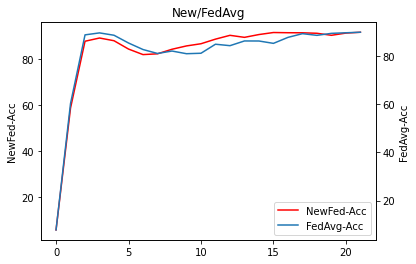

In [59]:
x = np.arange(len(S2.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc,'r',label='NewFed-Acc')
ax1.set_ylabel('NewFed-Acc')
ax1.set_title('New/FedAvg')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_acc2,label='FedAvg-Acc')
ax2.set_ylabel('FedAvg-Acc')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()